# LES configuration

Our LES runs for perturbation studies are at 100 m resolution over a 20 km domain. The starting profiles used are based on the state of the model at RCE at 1 km resolution over the same 20 km domain. This notebook contains the code and working to read these profiles and set up the LES run.

In [1]:
cd ~/git/wrf_lrf_les/analysis/

/home/561/tr2908/git/wrf_lrf_les/analysis


In [2]:
from dask.distributed import Client
import modules.rcemip_profile as rcemip
import modules.wrf_perturbation as wp
import modules.wrf_profile as wrfprof
import modules.atmosphere as at
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import xarray
import glob
import os

print("Report last updated at " + str(datetime.datetime.utcnow()) + ' UTC.')

Report last updated at 2023-11-09 03:21:12.418469 UTC.


In [3]:
client = Client()

## Settings

In [4]:
rce_dir   = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/1km/control/' # 1km data.
les_dir   = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/run/LES/RCE/'    # Output directory.
rce_start = wp.as_date('2000-04-01')                                  # RCE start time. 
rce_end   = wp.as_date('2000-06-01')                                  # RCE end time.
sst       = 301.15                                                    # SST [K].

## Read 1 km RCE data 

In [5]:
rce = xarray.open_mfdataset(rce_dir + 'wrfvars*', parallel=True)
rce_profs = rce.sel(time=slice(rce_start, rce_end)).mean('time', keep_attrs=True)

`eta_T` (K) is perturbation potential temperature minus `t0` (300 K) at full eta levels, and `eta_q` is water vapour mixing ratio in kg kg-1. Convert `eta_T` to full potential temperature (`theta`) and `eta_q` to have units of `g kg-1` (`q`).

In [6]:
rce_profs['theta'] = rce_profs.eta_T + 300 
rce_profs['q'] = rce_profs.eta_q
rce_profs['tk'] = rce_profs.eta_tk
rce_profs.theta.attrs = {'long_name': 'Potential temperature', 'units': 'K'}
rce_profs = rce_profs[['z', 'theta', 'q', 'tk']]

## Construct the input sounding file

The input sounding uses the RCE values from the 1 km simulations for the profiles of height, potential temperature, and specific humidity (water vapour mixing ratio). The surface values are produced using the RCE value for pressure, a value extrapolated from the profile for specific humidity, and the potential temperature based on the prescribed SST and surface pressure.

In [7]:
# Determine surface pressure from RCE outputs at 1 km resolution.
files = sorted(glob.glob(rce_dir+'wrfout_d01_2000-0[4-5]*'))
outdat = xarray.open_mfdataset(files, combine='nested', concat_dim='Time', parallel=True)
assert not np.any(outdat.XTIME.values < np.datetime64(rce_start))
assert not np.any(outdat.XTIME.values > np.datetime64(rce_end))

In [10]:
# Surface pressure in hPa.
surf_p = outdat.PSFC.mean().values / 100

# Interpolate profile to get surface q.
surf_q = np.interp(0, rce_profs.z, rce_profs.q)

# Surface potential temp is based on the pressure and SST.
surf_T = at.potential_temp(T=sst, p=surf_p)

# Write the profile to input_profile.
wrfprof.write_input_sounding(out_dir=les_dir, surface_p=surf_p, surface_q=surf_q, surface_T=surf_T, 
                             profile=rce_profs, indexed=False)

# Print the line to add to the top of the input_sounding.les file.
print('RCE surface values:')
print('Pressure:\t\t' + str(surf_p) + ' hPa')
print('Potential temperature:\t' + str(surf_T) + ' K')
print('Specific humidity:\t' + str(surf_q) + ' g kg-1')

RCE surface values:
Pressure:		1013.50125 hPa
Potential temperature:	299.99829400414353 K
Specific humidity:	0.014446758665144444 g kg-1


## Determine $\eta$-values for desired height profile

In [11]:
# Determine 1 km model top height at RCE.
vert_diff = rce_profs.z.diff('bottom_top').values[-15:].mean()
ztop_1km = np.round(rce_profs.z.max().values + vert_diff / 2, 0)

# Desired mass point heights will be interpolated versions of the RCEMIP suggested heights 
# to 3000 m, then 100 m gaps afterwards to the model top height of the RCE state at 1 km.
z_from = rcemip.suggested_heights()
z_from = np.concatenate([[0], z_from])[0:15]
z_idx = np.linspace(0, 1, len(z_from))
z_newidx = np.linspace(0, 1, int(len(z_from)*5))
z_les = np.round(np.interp(z_newidx, z_idx, z_from), 0)
z_les = np.concatenate([z_les[1:], np.arange(3100, ztop_1km, step=100)])
assert np.all(np.diff(z_les) <= 100) # Check that all vertical differences will be <= 100 m.

In [12]:
# Get 1 km mass-point etas.
eta_h_1km = xarray.open_dataset(rce_dir + '../RCE/wrfinput_d01').ZNU.values[0]

# Interpolate eta values using mass-point height (z) as the index.
interp = sp.interpolate.interp1d(rce_profs.z.values, eta_h_1km, fill_value='extrapolate' )
eta_h_les = interp(z_les) # Interpolated etas for mass points at z_les altitudes.

# Convert half (mass-point) etas to full etas (roughly by using means).
eta_les = (eta_h_les[0:len(eta_h_les)-1] + eta_h_les[1:]) / 2
eta_les = np.concatenate([[eta_h_les[0] - (eta_h_les[1] - eta_h_les[0]) / 2], eta_les])

# Discard etas < 0 that may occur because the 1 km simulation top height is less than 33000 m.
eta_les = eta_les[np.where(eta_les >= 0)]
eta_h_les = eta_h_les[0:len(eta_les)-1]
z_les = z_les[0:len(eta_les)-1]

# Sanity check on lengths of arrays and half levels appearing between mass levels.
assert np.all(eta_les[1:len(eta_les)] < eta_h_les)
assert np.all(eta_les[0:len(eta_les)-1] > eta_h_les)
assert len(eta_h_les) == len(eta_les)-1

print(np.array2string(np.round(eta_les,6), formatter={'float_kind':'{0:.6f},'.format}))

[0.999594, 0.998808, 0.998021, 0.997234, 0.996447, 0.995379, 0.993917,
 0.992287, 0.990657, 0.989083, 0.987456, 0.985779, 0.984047, 0.982316,
 0.980584, 0.978799, 0.976966, 0.975024, 0.973028, 0.971031, 0.969091,
 0.967049, 0.964794, 0.962538, 0.960338, 0.958137, 0.955783, 0.953275,
 0.950714, 0.948153, 0.945592, 0.942932, 0.940071, 0.937052, 0.934088,
 0.931123, 0.928113, 0.924857, 0.921293, 0.917730, 0.914219, 0.910713,
 0.906870, 0.902632, 0.898342, 0.893999, 0.889657, 0.885151, 0.880177,
 0.874951, 0.869776, 0.864601, 0.859321, 0.853514, 0.847233, 0.840953,
 0.834672, 0.828429, 0.821850, 0.814802, 0.807657, 0.800512, 0.793385,
 0.786074, 0.778375, 0.770491, 0.762606, 0.754722, 0.746848, 0.738784,
 0.730474, 0.722119, 0.713809, 0.705624, 0.697334, 0.688859, 0.680384,
 0.671910, 0.663576, 0.655442, 0.647369, 0.639296, 0.631223, 0.623305,
 0.615582, 0.607900, 0.600218, 0.592536, 0.585018, 0.577686, 0.570376,
 0.563067, 0.555757, 0.548621, 0.541666, 0.534717, 0.527768, 0.520826,
 0.514

As well as adding the eta level values above, the following settings should be changed in the `namelist.input` file to match the 1 km RCE output:

In [13]:
print('Value for ztop:\t\t' + str(int(ztop_1km)))
print('Value for e_vert:\t' + str(len(eta_les)))

Value for ztop:		32809
Value for e_vert:	372


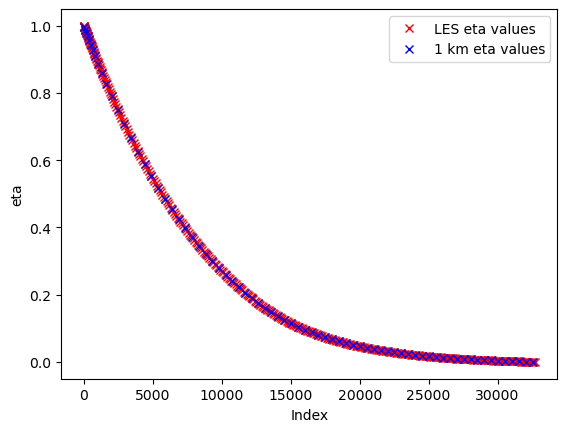

In [14]:
plt.plot(z_les, eta_h_les, 'x', color='red', label='LES eta values')
plt.plot(rce_profs.z.values, eta_h_1km, 'x', color='blue', label='1 km eta values')
plt.xlabel('Index')
plt.ylabel('eta')
plt.legend()

## Write profiles of temperature and water vapour mixing ratio

Use simple linear inteprolation/extrapolation to find the values of specific humidity and temperature at each of the new eta levels.

In [15]:
# Interpolate q and temperature on half (mass) points.
interp_q = sp.interpolate.interp1d(eta_h_1km, rce_profs.q.values, fill_value='extrapolate')
interp_tk = sp.interpolate.interp1d(eta_h_1km, rce_profs.tk.values, fill_value='extrapolate')

rce_q = interp_q(eta_h_les)
rce_tk = interp_tk(eta_h_les)

Plot temperature profiles to see that the interpolation looks ok:

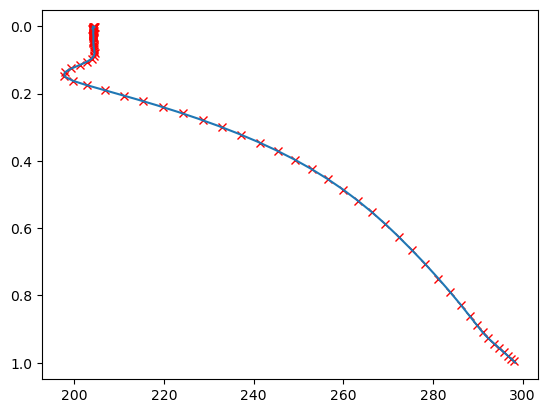

In [16]:
plt.plot(rce_profs.tk.values, eta_h_1km, 'x', color='red')
plt.plot(rce_tk, eta_h_les)
plt.gca().invert_yaxis()

Plot specific humidity profiles to see that the interpolation looks ok:

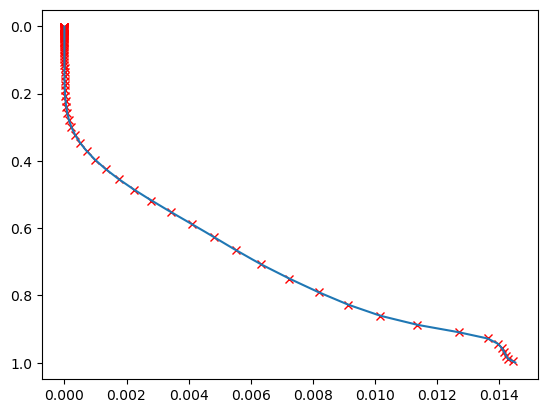

In [17]:
plt.plot(rce_profs.q.values, eta_h_1km, 'x', color='red')
plt.plot(rce_q, eta_h_les)
plt.gca().invert_yaxis()

In [18]:
assert not os.path.exists(les_dir + '/RCE_T'), 'Output file RCE_T already exists.'
assert not os.path.exists(les_dir + '/RCE_q'), 'Output file RCE_q already exists.'
pd.DataFrame.from_dict({'q': rce_q}).to_csv(les_dir+'/RCE_q', header=False, index=False)
pd.DataFrame.from_dict({'T': rce_tk}).to_csv(les_dir+'/RCE_T', header=False, index=False)

## Check in on heights generated by `ideal.exe`:

**Important** Now run `run_ideal.sh` to generate the `wrfinput` file using the updated eta values, before running the next code blocks. The resulting heights will be different from the desired heights in `z_les`, but they should have similar spacing across the range.

In [19]:
les_input = xarray.open_dataset(les_dir+'/wrfinput_d01')
level_heights = les_input.Z_BASE.sel(Time=0).values
print('Maximum grid point height difference: ' + str(int(np.max(np.abs(np.diff(level_heights))))) + ' m')

Maximum grid point height difference: 106 m


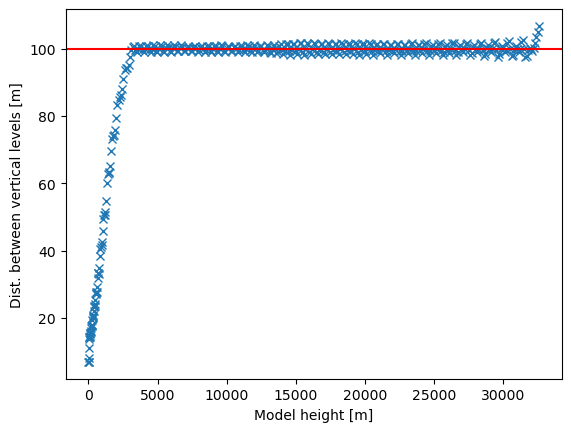

In [20]:
plt.plot(level_heights[0:len(level_heights)-1], np.diff(level_heights), 'x')
plt.axhline(100, color='red')
plt.xlabel('Model height [m]')
plt.ylabel('Dist. between vertical levels [m]')
plt.show()